# Workflow RSAM & DSAR

**The first step is to calculate the data stream. There are several sub-steps:**
1. After removing the instrument response to the seismic signals, apply a bandpass filter to each 24 hours of data, between 2-4.5, 4-8 and 8-16 Hz (corresponding to the RSAM, MF and HF bands).
2. Compute the absolute values of each signal.
3. Subdivide the signals into 10 minutes intervals. For each interval, compute the average value as the RSAM, MF and HF datapoints assigned to that interval.
4. Removing outliers associated with regional earthquakes is optional. We procced as follow: from (2), subdivide the signals into 10 minutes intervals. 
    1. Calculated the mean and standard deviation (mu and sigma) for each interval. 
    2. Apply z-score normalization in log-space to the interval using mu and sigma. 
    3. Check if any value in the interval exceeds a threshold of 3.2 standard deviations above the mean. 
    4. If yes, exclude data points from a 150s mask starting 15s before the outlier located. 
    5. Calculate the average value in the interval excluding points inside the mask: this the RSAM, MF and HF value for the interval.
**To calculate the DSAR, procced as follow:**
1. Integrate the bandpass filtered MF and HF data with time.
2. Take the absolute value and compute averages on 10-minute intervals.
3. Compute the ratio between integrated MF and HF.
**For computing the DSAR median feature proposed as a precursor in this paper follow:**
1. Every 10 minutes in the DSAR data stream, take a 48 hours window (looking backwards).
2. For each window, compute the median.
3. Construct the feature time series with point every 10 minutes corresponding the medians computed from the 48 hours windows.


In [1]:
import numpy as np
import pandas as pd
import obspy
import obspy.signal.filter
import sys           
sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()
import datetime
import scipy
import glob
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read txt-file with UTC times and type of activity
df_activity = pd.read_csv('../../MtStHelens_activity/mt_st_helens_activity.txt', header=1, skiprows=9)
df_activity.set_index('UTC',inplace=True)
df_activity.index = pd.to_datetime(df_activity.index).tz_localize(None)
df_activity

,activity
UTC,
2004-09-23 09:00:00,s
2004-09-25 19:00:00,q
2004-09-26 00:00:00,c
2004-09-29 00:00:00,q
2004-10-01 19:02:00,a
2004-10-02 19:14:00,a
2004-10-02 19:14:00,t
2004-10-03 09:50:00,t
2004-10-03 11:30:00,et


In [18]:
def read_taper_stream(year,jday, net, sta, cha):
#     try:
#         starttime = obspy.UTCDateTime(year=year, julday=int(jday), minute=-30, strict=False)
#     except ValueError:
#         print('exception starttime --> PROBLEM')
#     try:
#         endtime = obspy.UTCDateTime(year=year, julday=int(jday)+1, minute=+30, strict=False)
#     except ValueError:
#         endtime = obspy.UTCDateTime(year=year+1, julday=1, minute=+30, strict=False)
        
    st = obspy.Stream()
#     st_d = obspy.Stream()
    try:
        # this stream will be used for RSAM and DSAR calculations
        #st_read = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/{}/EDM.UW.2004.{}'.format(jday,jday))
        st_read = client.get_waveforms(network=net, station=sta, channel=cha,
                                       year='{}'.format(year), doy='{}'.format(jday))
        st += st_read
        st.detrend('demean')
        st.taper(0.05, type='hann')
        st.merge(fill_value=0)
        
        # correct insrument response
        inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
        pre_filt = [1e-3, 5e-2, 45, 50]
        water_level = 60

        st[0].remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                                  pre_filt=pre_filt, output="VEL", water_level=water_level,
                                  plot=False)
        
        # correct positive dip
        dip = inv.get_orientation(st[0].id, datetime=st[0].stats.starttime)['dip']
        if dip > 0:
            st[0].data *= -1
        
#         st.trim(obspy.UTCDateTime(year=year, julday=jday), obspy.UTCDateTime(year=year, julday=jday+1))
        
#         # this stream will be safed for the plot, therefor the stream is downsamplet but not processed
#         st_dec = st_read.copy()
#         st_dec = st_dec.decimate(15)  # downsampling for plot only
#         #st_dec.detrend('demean')
#         st_d += st_dec
#         #st_d.merge()
        
    except:
        print('pass {}'.format(jday))
    return(st)

In [39]:
st = client.get_waveforms(network=net, station=sta, channel=cha,
                               year='{}'.format(year), doy='{}'.format(268))

st.detrend('demean')
st.taper(0.05, type='hann')
# st.merge(fill_value=0)

# correct insrument response
inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
pre_filt = [1e-3, 5e-2, 45, 50]
water_level = 60

for tr in st:
    tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                              pre_filt=pre_filt, output="VEL", water_level=water_level,
                              plot=False)

    # correct positive dip
    dip = inv.get_orientation(st[0].id, datetime=tr.stats.starttime)['dip']
    if dip > 0:
        tr.data *= -1
st

5 Trace(s) in Stream:
UW.EDM..EHZ | 2004-09-24T00:00:00.000000Z - 2004-09-24T00:40:20.060000Z | 100.0 Hz, 242007 samples
UW.EDM..EHZ | 2004-09-24T00:40:20.081000Z - 2004-09-24T01:39:10.071000Z | 100.0 Hz, 353000 samples
UW.EDM..EHZ | 2004-09-24T01:39:10.091000Z - 2004-09-24T02:38:10.081000Z | 100.0 Hz, 354000 samples
UW.EDM..EHZ | 2004-09-24T02:38:10.100900Z - 2004-09-24T15:50:15.230900Z | 100.0 Hz, 4752514 samples
UW.EDM..EHZ | 2004-09-24T15:50:33.251300Z - 2004-09-24T23:59:59.991300Z | 100.0 Hz, 2936675 samples

In [40]:
def preprocessing(year,jday, net, sta, cha):

    try:
        # this stream will be used for RSAM and DSAR calculations
        #st = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/{}/EDM.UW.2004.{}'.format(jday,jday))
        st = client.get_waveforms(network=net, station=sta, channel=cha,
                                       year='{}'.format(year), doy='{}'.format(jday))

        st.detrend('demean')
        st.taper(0.05, type='hann')
#         st.merge(fill_value=0)
        
        # correct insrument response
        inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
        pre_filt = [1e-3, 5e-2, 45, 50]
        water_level = 60
        
        for tr in st:
            tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
                                      pre_filt=pre_filt, output="VEL", water_level=water_level,
                                      plot=False)

            # correct positive dip
            dip = inv.get_orientation(st[0].id, datetime=tr.stats.starttime)['dip']
            if dip > 0:
                tr.data *= -1
        
    except:
        print('pass {}'.format(jday))
    return(st)

In [14]:
st_read = client.get_waveforms(network=net, station=sta, channel=cha,
                              starttime=starttime, endtime=endtime)
st_read

NameError: name 'net' is not defined

In [15]:
st = client.get_waveforms(network='UW', station='EDM', channel='EHZ',
                               year='{}'.format(year), doy='{}'.format(jday))
st

10 Trace(s) in Stream:
UW.EDM..EHZ | 2004-06-09T11:05:29.009900Z - 2004-06-09T11:10:19.999900Z | 100.0 Hz, 29100 samples
UW.EDM..EHZ | 2004-06-09T11:10:20.020900Z - 2004-06-09T12:06:00.010900Z | 100.0 Hz, 334000 samples
UW.EDM..EHZ | 2004-06-09T12:06:00.031000Z - 2004-06-09T13:01:30.021000Z | 100.0 Hz, 333000 samples
UW.EDM..EHZ | 2004-06-09T13:01:30.040900Z - 2004-06-09T13:57:00.030900Z | 100.0 Hz, 333000 samples
UW.EDM..EHZ | 2004-06-09T13:57:00.050900Z - 2004-06-09T14:52:30.040900Z | 100.0 Hz, 333000 samples
UW.EDM..EHZ | 2004-06-09T14:52:30.061000Z - 2004-06-09T15:48:00.051000Z | 100.0 Hz, 333000 samples
UW.EDM..EHZ | 2004-06-09T15:48:00.071000Z - 2004-06-09T16:43:10.061000Z | 100.0 Hz, 331000 samples
UW.EDM..EHZ | 2004-06-09T16:43:10.080900Z - 2004-06-09T17:37:30.070900Z | 100.0 Hz, 326000 samples
UW.EDM..EHZ | 2004-06-09T17:37:30.090900Z - 2004-06-09T18:32:20.080900Z | 100.0 Hz, 329000 samples
UW.EDM..EHZ | 2004-06-09T18:32:20.101000Z - 2004-06-10T00:00:00.011000Z | 100.0 Hz, 196

In [16]:
year = 2004
jdays = ['161']#, '160', '161']
st = obspy.Stream()
st_d = obspy.Stream()
for jday in jdays:
    st_read = read_taper_stream(year,jday)
    st += st_read
    #st_d += st_dec
st.plot()
st

TypeError: read_taper_stream() missing 3 required positional arguments: 'net', 'sta', and 'cha'

In [18]:
def RSAM(data, samp_rate, datas, freq, Nm, N):
    filtered_data = obspy.signal.filter.bandpass(data, freq[0], freq[1], samp_rate)
    filtered_data = abs(filtered_data[:Nm])
    datas.append(filtered_data.reshape(-1,N).mean(axis=-1)*1.e9)
    return(datas)

In [19]:
def DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N):
    # compute dsar
    data = scipy.integrate.cumtrapz(data, dx=1./100, initial=0) # vel to disp
    data -= np.mean(data) # detrend('mean')
    j = freqs_names.index('mf')
    mfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    mfd = abs(mfd[:Nm])
    mfd = mfd.reshape(-1,N).mean(axis=-1)
    j = freqs_names.index('hf')
    hfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    hfd = abs(hfd[:Nm])
    hfd = hfd.reshape(-1,N).mean(axis=-1)
    dsar = mfd/hfd
    datas.append(dsar)
    return(datas, dsar)

In [20]:
def nDSAR(datas,dsar):
    ndsar = dsar/sc.stats.zscore(dsar)
    datas.append(ndsar)
    return(datas, ndsar)

In [12]:
# def nDSAR(datas, dsar):
#     ndsar = dsar+np.mean(dsar)/np.std(dsar)
#     datas.append(ndsar)
#     return(datas)

In [22]:
# creates a df for each trace and append this df to a daily df
def create_df(datas, ti, freqs_names, df):
    datas = np.array(datas)
    time = [(ti+j*600).datetime for j in range(datas.shape[1])]
    df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
    df = pd.concat([df, df_tr])
    return(df)

In [10]:
# main function
def freq_bands_taper(year,jday):   
    ''' 
    calculate and store power in 10 min long time windows for different frequency bands
    sensor measured ground velocity
    freqs: list contains min and max frequency in Hz
    dsar: float represents displacement (integration of)'''
    
    net = 'UW'
    sta = 'SHW'
    cha =  '*'
    
    freqs_names = ['rsam','mf','hf', 'dsar', 'ndsar']
    df = pd.DataFrame(columns=freqs_names)
    daysec = 24*3600
    freqs = [[2, 5], [4.5, 8], [8,16]]
    
    st = preprocessing(year,jday, net, sta, cha)

    for tr in st:
        datas = []
        data = tr.data
        samp_rate = tr.meta['sampling_rate']
        ti = tr.meta['starttime']
        # round start time to nearest 10 min increment
        tiday = obspy.UTCDateTime("{:d}-{:02d}-{:02d} 00:00:00".format(ti.year, ti.month, ti.day)) # date
        ti = tiday+int(np.round((ti-tiday)/600))*600 # nearest 10 min to starttime
        N = int(600*samp_rate)    # 10 minute windows in seconds
        Nm = int(N*np.floor(len(data)/N)) # np.floor rounds always to the smaller number
        # seconds per day (86400) * sampling rate (100) -> datapoints per day

        for freq, frequ_name in zip(freqs, freqs_names[:3]):
            datas = RSAM(data, samp_rate, datas, freq, Nm, N) # get RSAM for different frequency bands

        datas, dsar = DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
#         datas = nDSAR(datas, dsar)

        df = create_df(datas, ti, freqs_names, df)

        if not os.path.exists('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/{}/{}/{}'.format(year,tr.stats['station'],tr.stats['channel'])):
            os.makedirs('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/{}/{}/{}'.format(year,tr.stats['station'],tr.stats['channel']))

        df.to_csv('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/{}/{}/{}/nDSAR_taper_{}.csv'.format(year,tr.stats['station'],tr.stats['channel'],jday), index=True, index_label='time')
        
    return()

In [ ]:
# calculate frequencie bands
year = 2004
jdays = ['{:03d}'.format(jday) for jday in range(1,367)]
#print(jdays)
for i, jday in enumerate(jdays,1):
    freq_bands_taper(year,jday)
    
    sys.stdout.write('\r{} of {}'.format(i, len(jdays)))
    sys.stdout.flush()

341 of 366

In [23]:
year = 2004
jday = 265
    
net = 'UW'
sta = 'EDM'
cha = 'EHZ'
    
freqs_names = ['rsam','mf','hf', 'dsar']
df = pd.DataFrame(columns=freqs_names)
daysec = 24*3600
freqs = [[2, 5], [4.5, 8], [8,16]]

st = read_taper_stream(year,jday, net, sta, cha)

if len(st)>0: # if stream not empty
    for tr in st:
        datas = []
        data = tr.data
        samp_rate = tr.meta['sampling_rate']
        ti = tr.meta['starttime']
        # round start time to nearest 10 min increment
        tiday = obspy.UTCDateTime("{:d}-{:02d}-{:02d} 00:00:00".format(ti.year, ti.month, ti.day)) # date
        ti = tiday+int(np.round((ti-tiday)/600))*600 # nearest 10 min to starttime
        N = int(600*samp_rate)    # 10 minute windows in seconds
        Nm = int(N*np.floor(len(data)/N)) # np.floor rounds always to the smaller number
        # seconds per day (86400) * sampling rate (100) -> datapoints per day
        
#         # Remove outliers
#         mean = data[:Nm].reshape(-1,N).mean(axis=-1)*1.e9 # mean in 20 min interval --> 144 enteries per day
#         std = data[:Nm].reshape(-1,N).std(axis=-1)*1.e9
#         scipy.stats.zscore(,


        for freq, frequ_name in zip(freqs, freqs_names[:3]):
            datas = RSAM(data, samp_rate, datas, freq, Nm, N) # get RSAM for different frequency bands

        datas, dsar = DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
#         datas = nDSAR(datas, dsar)

        df = create_df(datas, ti, freqs_names, df)
df

,rsam,mf,hf,dsar
2004-09-21 00:00:00,0.097316,0.063682,0.050651,2.602262
2004-09-21 00:10:00,1.377732,0.955950,0.636603,3.068412
2004-09-21 00:20:00,4.940154,3.902926,2.879278,2.647254
2004-09-21 00:30:00,11.380989,8.167263,5.926473,2.766327
2004-09-21 00:40:00,13.873521,9.260291,6.218442,3.008339
...,...,...,...,...
2004-09-21 23:10:00,19.148524,17.790513,13.014452,2.548391
2004-09-21 23:20:00,14.083695,14.712153,12.825602,2.017853
2004-09-21 23:30:00,4.712093,3.971734,3.118418,2.456661
2004-09-21 23:40:00,1.613466,1.256574,0.817338,2.984998


In [13]:
year = 2004
jday = 265
    
net = 'UW'
sta = 'EDM'
cha = 'EHZ'
    
freqs_names = ['rsam','mf','hf', 'dsar', 'ndsar']
df = pd.DataFrame(columns=freqs_names)
daysec = 24*3600
freqs = [[2, 5], [4.5, 8], [8,16]]

st = read_taper_stream(year,jday, net, sta, cha)

if len(st)>0: # if stream not empty
    for tr in st:
        datas = []
        data = tr.data
        samp_rate = tr.meta['sampling_rate']
        ti = tr.meta['starttime']
        # round start time to nearest 10 min increment
        tiday = obspy.UTCDateTime("{:d}-{:02d}-{:02d} 00:00:00".format(ti.year, ti.month, ti.day)) # date
        ti = tiday+int(np.round((ti-tiday)/600))*600 # nearest 10 min to starttime
        N = int(600*samp_rate)    # 10 minute windows in seconds
        Nm = int(N*np.floor(len(data)/N)) # np.floor rounds always to the smaller number
        # seconds per day (86400) * sampling rate (100) -> datapoints per day
        
#         # Remove outliers
#         mean = data[:Nm].reshape(-1,N).mean(axis=-1)*1.e9 # mean in 20 min interval --> 144 enteries per day
#         std = data[:Nm].reshape(-1,N).std(axis=-1)*1.e9
#         scipy.stats.zscore(,


        for freq, frequ_name in zip(freqs, freqs_names[:3]):
            datas = RSAM(data, samp_rate, datas, freq, Nm, N) # get RSAM for different frequency bands

        datas, dsar = DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
#         datas = nDSAR(datas, dsar)

        df = create_df(datas, ti, freqs_names, df)
df

,rsam,mf,hf,dsar,ndsar
2004-09-21 00:00:00,0.097316,0.063682,0.050651,2.602262,9.460330
2004-09-21 00:10:00,1.377732,0.955950,0.636603,3.068412,9.926480
2004-09-21 00:20:00,4.940154,3.902926,2.879278,2.647254,9.505322
2004-09-21 00:30:00,11.380989,8.167263,5.926473,2.766327,9.624396
2004-09-21 00:40:00,13.873521,9.260291,6.218442,3.008339,9.866407
...,...,...,...,...,...
2004-09-21 23:10:00,19.148524,17.790513,13.014452,2.548391,9.406460
2004-09-21 23:20:00,14.083695,14.712153,12.825602,2.017853,8.875922
2004-09-21 23:30:00,4.712093,3.971734,3.118418,2.456661,9.314730
2004-09-21 23:40:00,1.613466,1.256574,0.817338,2.984998,9.843066


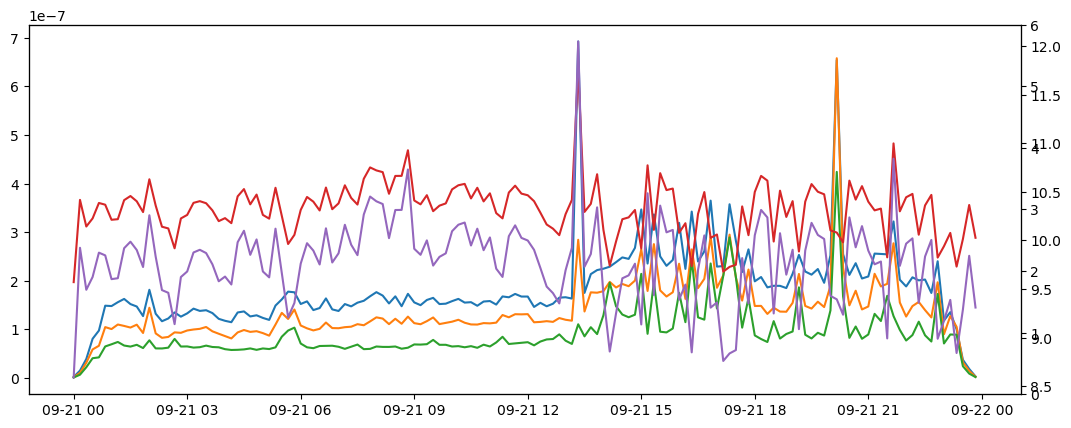

In [52]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))
# ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
#            label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))
ax.plot(df['rsam'], label='RSAM')
ax.plot(df['mf'], label='MF')
ax.plot(df['hf'], label='HF')
ax.plot(np.nan, label='DSAR')

ax2 = ax.twinx()
ax2.plot(df['dsar'], label='DSAR', color='C3')
ax2.set_ylim(0,6)

ax3 = ax.twinx()
ax3.plot(df['ndsar'], label='nDSAR', color='C4')

#ax.legend(ncol=4)

In [ ]:
# calculate frequencie bands AND save stream
jdays = ['{:03d}'.format(jday) for jday in range(1,366)]
#print(jdays)
st_long = obspy.Stream()
for i, jday in enumerate(jdays,1):
    st_dec = freq_bands_taper(jday)
    st_long += st_dec
    
    sys.stdout.write('\r{} of {}\n'.format(i, len(jdays)))
    sys.stdout.flush()

st_long.write("tmp_2005/st_2005.mseed", format="MSEED") # save stream
st_long

In [ ]:
# # to save a masked stream

# st_copy = st_long.copy() # copy original stream

# for tr in st_copy: # demask stream
#     if isinstance(tr.data, np.ma.masked_array):
#         tr.data = tr.data.filled(np.nan)

# #st_copy.write("tmp/st_2004.mseed", format="MSEED") # save stream copy (demasked)

## Read

In [ ]:
st_r = obspy.read('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/tmp_2005/st_2005.mseed')
st_r.detrend('demean')
#st_r.merge()
st_r.plot()
st_r

In [ ]:
st_long = st_r.copy()
st_long.merge()

In [8]:
all_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/EHZ/*_taper_*.csv'))
# all_files = all_files[:]
all_files

[]

In [113]:
# all_files = sorted(glob.glob('../data/tmp_2004/EDM/_tmp_taper_*.csv'))
# all_files = all_files[242:275]
li = []
for filename in all_files:
    frame = pd.read_csv(filename)
    li.append(frame)

df = pd.concat(li, axis=0, ignore_index=True)
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df

,rsam,mf,hf,dsar,ndsar
time,,,,,
2004-09-15 00:00:00,0.522003,0.525473,0.488477,1.816259,7.592674
2004-09-15 00:10:00,5.934883,5.078652,4.449601,2.201330,7.977744
2004-09-15 00:20:00,19.549337,20.793274,16.924304,2.284811,8.061226
2004-09-15 00:30:00,26.428776,21.344511,18.749988,2.224051,8.000466
2004-09-15 00:40:00,51.847633,42.710197,24.022323,3.397003,9.173418
...,...,...,...,...,...
2004-10-16 23:00:00,2536.201388,1407.898453,504.863109,4.659084,20.618271
2004-10-16 23:10:00,2488.017022,1415.173178,508.575858,4.679850,20.639037
2004-10-16 23:20:00,2577.754450,1406.603365,512.802163,4.622784,20.581971


## Simple Plot

#### Rolling

In [102]:
df_roll = df.rolling('1H', center=True).median()
df_roll

,rsam,mf,hf,dsar,ndsar
time,,,,,
2004-09-15 00:00:00,3.827629,2.054326,4.194917,1.196830,3.427769
2004-09-15 00:10:00,5.728252,3.208924,6.816224,1.209426,3.440365
2004-09-15 00:20:00,6.670033,3.488959,7.627559,1.283519,3.514458
2004-09-15 00:30:00,9.827374,4.597138,9.349660,1.270923,3.501862
2004-09-15 00:40:00,11.928046,5.513641,10.463916,1.263283,3.494221
...,...,...,...,...,...
2004-10-16 23:10:00,472.598931,79.529918,40.414437,4.152639,13.691684
2004-10-16 23:20:00,272.016612,43.509918,24.383593,4.243725,13.782770
2004-10-16 23:30:00,165.792237,28.345130,16.024471,4.153473,13.692518


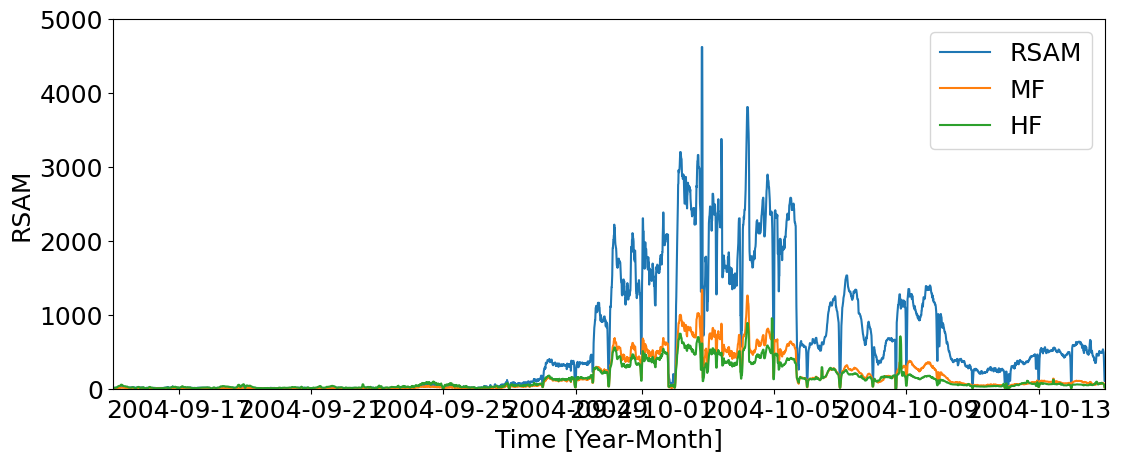

In [103]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))
# ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
#            label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))

# ax.plot(df_roll['rsam'], label='RSAM')
# ax.plot(df_roll['mf'], label='MF')
# ax.plot(df_roll['hf'], label='HF')
ax.plot(df_roll['dsar'], label='DSAR','k')

# ax.plot(np.nan, label='DSAR')
# ax.plot(np.nan, label='nDSAR')

# ax2 = ax.twinx()
# ax2.plot(df_roll['dsar'], label='DSAR', color='C3')
# ax3 = ax.twinx()
# ax3.plot(df_roll['ndsar'], label='nDSAR', color='C4')

ax.set_xlabel('Time [Year-Month]')
ax.set_ylim(0,5e3)
ax.set_ylabel('RSAM')
# ax2.set_ylim(0,5)
# ax2.set_ylabel('DSAR')
# ax3.set_ylim(0,50)
# ax3.set_ylabel('nDSAR')
# ax3.spines.right.set_position(("axes", 1.07))

# for idx in df_activity.index[:15]:
#     ax.axvline(idx, color='black', linewidth=1)
ax.set_xlim(datetime.datetime(2004,9,15),datetime.datetime(2004,10,15))


ax.legend(ncol=1)
#fig.savefig('../plots/2004_taper_roll1.png', bbox_inches='tight', dpi=300)

### Resampling

In [114]:
df_res = df.resample('0.5H').mean()
df_res

,rsam,mf,hf,dsar,ndsar
time,,,,,
2004-09-15 00:00:00,8.668741,8.799133,7.287460,2.100800,7.877215
2004-09-15 00:30:00,37.034385,29.801466,20.603192,2.721620,8.498035
2004-09-15 01:00:00,54.989358,39.204988,25.608383,2.849310,8.625725
2004-09-15 01:30:00,50.952859,47.677690,43.138641,2.037628,7.814043
2004-09-15 02:00:00,73.124095,64.000181,53.545776,2.217282,7.993696
...,...,...,...,...,...
2004-10-16 21:30:00,2284.770674,1195.354839,454.613161,4.443485,20.402673
2004-10-16 22:00:00,2315.941542,1260.996460,467.474887,4.526176,20.485363
2004-10-16 22:30:00,2214.366453,1230.221687,455.989816,4.544750,20.503937


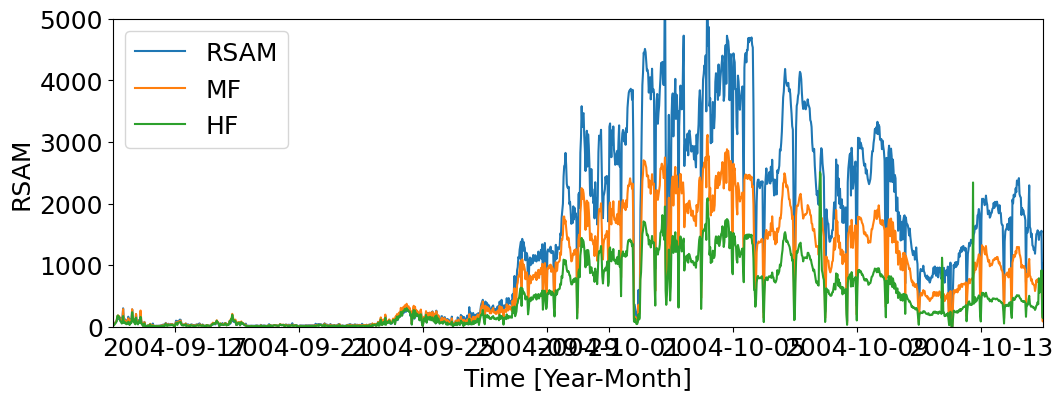

In [115]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,1, sharex=True, figsize=(12, 4))

ax.plot(df_res['rsam'], label='RSAM')
ax.plot(df_res['mf'], label='MF')
ax.plot(df_res['hf'], label='HF')
# ax.plot(np.nan, label='DSAR')
# ax.plot(np.nan, label='nDSAR')

# ax2 = ax.twinx()
# ax2.plot(df_res['dsar'], label='DSAR', color='C3')
# ax3 = ax.twinx()
# ax3.plot(df_res['ndsar'], label='nDSAR', color='C4')

ax.set_xlabel('Time [Year-Month]')
ax.set_ylim(0,5e3)
ax.set_ylabel('RSAM')
# ax2.set_ylim(0,5)
# ax2.set_ylabel('DSAR')
# ax3.set_ylim(0,50)
# ax3.set_ylabel('nDSAR')
ax3.spines.right.set_position(("axes", 1.07))

#ax.axvline(df_activity.index[0], color='black', linewidth=3, label='Eruption')
# for idx in df_activity.index[:15]:
#     ax.axvline(idx, color='black', linewidth=1)
ax.set_xlim(datetime.datetime(2004,9,15),datetime.datetime(2004,10,15))
#ax.set_ylim(-5e10,1.4e12)
#ax2.set_ylim(1,5.5)
# start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(start, end, 6))

ax.legend(ncol=1, loc='upper left')
#fig.savefig('../plots/2004_sep_taper_res8.png', bbox_inches='tight', dpi=300)

In [ ]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))
# ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
#            label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))
ax.plot(df_roll['rsam'], label='RSAM')
ax.plot(df_roll['mf'], label='MF')
ax.plot(df_roll['hf'], label='HF')
ax.plot(np.nan, label='DSAR')

ax2 = ax.twinx()
ax2.plot(df_roll['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
ax.legend(ncol=4)

In [ ]:
np.arange(start, end, 6)

In [ ]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,1, sharex=True, figsize=(16, 4))
# ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
#            label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))
ax.plot(df_res['rsam'], label='RSAM')
ax.plot(df_res['mf'], label='MF')
ax.plot(df_res['hf'], label='HF')
ax.plot(np.nan, label='DSAR')

ax2 = ax.twinx()
ax2.plot(df_res['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
plt.xticks(rotation=45)
ax.set_xlabel('Time [Year-Month]')
ax.set_ylabel('RSAM')
ax2.set_ylabel('DSAR')

ax.axvline(datetime.datetime(2004, 9, 23), color='black', linewidth=3, label='Eruption')
ax.legend(ncol=2)
#fig.savefig('../plots/2004_taper_res2.png', bbox_inches='tight', dpi=300)

### Trim

In [68]:
st

1 Trace(s) in Stream:
UW.EDM..EHZ | 2004-09-21T00:00:00.009900Z - 2004-09-22T00:00:00.009900Z | 100.0 Hz, 8640001 samples

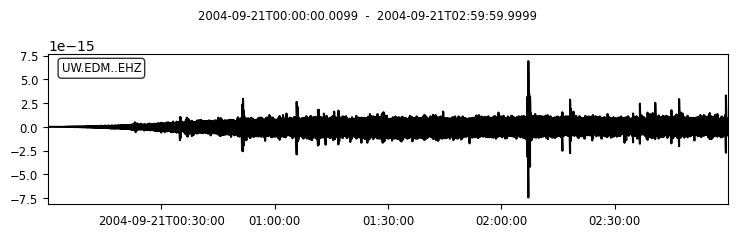

1 Trace(s) in Stream:
UW.EDM..EHZ | 2004-09-21T00:00:00.009900Z - 2004-09-21T02:59:59.999900Z | 100.0 Hz, 1080000 samples

In [69]:
# trim stream
start_trim = obspy.UTCDateTime(2004,9,21)
end_trim = obspy.UTCDateTime(2004,9,21,3)
st_trim = st.copy()
st_trim.trim(start_trim, end_trim)
st_trim.plot()
st_trim.merge()
st_trim

In [ ]:
# trim
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
ax[0].plot(st_trim[0].times('matplotlib'), st_trim[0].data, color='k', 
           label='{}.{}..{}'.format(st_trim[0].stats['network'],
                                    st_trim[0].stats['station'],
                                    st_trim[0].stats['channel']))
ax[1].plot(df['rsam'], label='LF')
ax[1].plot(df['mf'], label='MF')
ax[1].plot(df['hf'], label='HF')
ax[1].plot(np.nan, label='DSAR')

ax2 = ax[1].twinx()
ax2.plot(df['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
ax[1].set_xlim(start_trim.datetime, end_trim.datetime)

ax[1].set_ylabel('RSAM')
ax2.set_ylabel('DSAR')
ax[0].legend(loc='upper left')
ax[1].legend(ncol=4, loc='upper left')

fig.savefig('plots/2005_EDM_2m_1.png', bbox_inches='tight', dpi=300)

### Plot with stream

In [ ]:
    fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
    ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
               label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))
    #ax[0].set_ylim(-4000,4000)
    ax[1].plot(df['rsam'], label='RSAM')
    ax[1].plot(df['mf'], label='MF')
    ax[1].plot(df['hf'], label='HF')
    ax[1].plot(np.nan, label='DSAR')

    ax2 = ax[1].twinx()
    ax2.plot(df['dsar'], label='DSAR', color='C3')
    #ax2.set_ylim(0,2.5)

    ax[0].legend(loc='upper left')
    ax[1].legend(ncol=4, loc='upper left')
    fig.savefig('plots/2005_EDM_1y_taper.png', bbox_inches='tight', dpi=300)

In [ ]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k')
#ax[0].set_ylim(-4000,4000)
ax[1].plot(df['rsam'], label='RSAM')
ax[1].plot(df['mf'], label='MF')
ax[1].plot(df['hf'], label='HF')
ax[1].plot(np.nan, label='DSAR')

ax2 = ax[1].twinx()
ax2.plot(df['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
ax[1].legend(ncol=4)

## Multi-year plot

In [ ]:
years = range(2004,2011)
sta = 'EDM'
fig, ax = plt.subplots(len(years),1, figsize=(6.4*2, 4.8/2*len(years)))
for i, year in enumerate(years):
    
    # load RSA and DSAR
    all_files = sorted(glob.glob('tmp_{}/{}/_tmp_taper_*.csv'.format(year,sta)))
    #all_files = all_files[1:]
    li = []
    for filename in all_files:
        frame = pd.read_csv(filename)
        li.append(frame)

    df = pd.concat(li, axis=0, ignore_index=True)
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    
    # plot
    ax[i].plot(df['rsam'], label='RSAM', alpha=0.8)
    ax[i].plot(df['mf'], label='MF', alpha=0.8)
    ax[i].plot(df['hf'], label='HF', alpha=0.8)
    ax[i].plot(np.nan, label='DSAR', alpha=0.8)
    ax[i].set_ylabel('RSAM')
    ax[i].set_ylim(0,1e12)
#     ax[i].set_ylim(1e7,1e13)
#     ax[i].set_yscale('log')

    ax2 = ax[i].twinx()
    ax2.plot(df['dsar'], color='C3', alpha=0.8)
    ax2.set_ylabel('DSAR')
    ax2.set_ylim(0,10)
#     ax2.set_ylim(1e-1,10)
#     ax2.set_yscale('log')

    # plot vertical lines where volcano activityes were recordet
    for index,row in df_activity.iterrows():
        if index.year == year: # plot only one year per subplot
            index=str(index)
            if len(row[0])==1: # plot all start times as solid line
                ax[i].axvline(datetime.datetime.strptime(index,"%Y-%m-%d %H:%M:%S"), linestyle='-', color='k')
            if len(row[0])>1: # plot all end times as dotted line
                ax[i].axvline(datetime.datetime.strptime(index,"%Y-%m-%d %H:%M:%S"), linestyle=':', color='k')
                
                
ax[0].legend(loc='upper left', ncol=4)
fig.savefig('plots/{}_{}_{}_taper2.png'.format(years[0],years[-1],sta), bbox_inches='tight', dpi=300)

In [ ]:
std_rsam = np.std(df['rsam'])
std_mf = np.std(df['mf'])
std_hf = np.std(df['hf'])
std_dsar = np.std(df['dsar'])

mean_rsam = np.mean(df['rsam'])
mean_mf = np.mean(df['mf'])
mean_hf = np.mean(df['hf'])
mean_dsar = np.mean(df['dsar'])

In [ ]:
df

In [ ]:
# diese df entält nur werte die ALLE im threshold liegen
factor = 10
#df2 = df[ ( df['rsam'] < mean_rsam+factor*std_rsam) & (df['rsam'] > mean_rsam-factor*std_rsam)]
df2 = df[ ( df['rsam'] < 8e9) & (df['rsam'] > 7e9) & #rsam 7.
         ( df['mf'] < 7e9) & (df['mf'] > 6e9) ] #mf 6.
df2

In [ ]:
df_test = df.copy()
idx_rsam = ( df['rsam'] < 8e9) & (df['rsam'] > 7e9)
df_test['rsam'][~idx_rsam] = np.nan
#df_test

In [ ]:
df_roll_mean = df_roll.resample('1H').median()